In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../")
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pickle
import glob
from tqdm.notebook import trange, tqdm
import json
import re
import pandas as pd
import numpy as np
from collections import defaultdict
from features import merge_entries
from sklearn.preprocessing import StandardScaler
from features import merge_entries, get_transformer


from utills import cartesian_product, chunker
from train_utils import generate_unique_pairs, get_random_author_excluding, generate_doc_pairs_no_chunking, fit_transformers_no_chunking, vectorize_no_chunking


from sklearn.linear_model import SGDClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc

In [3]:
import matplotlib.pyplot as plt
import matplotlib.style as style
import tikzplotlib
%matplotlib inline

In [4]:

from plotly.offline import init_notebook_mode
import plotly.offline as py
import plotly.graph_objs as go
init_notebook_mode(connected=True)

In [5]:
BASE_PATH = '../data/reddit/'
COMPUTED_DATA_PATH = '../temp_data/reddit/preprocessed/'
TEMP_DATA = '../temp_data/reddit/unchunked/'
FIGURES_PATH = '../figures/'

In [6]:
with open(COMPUTED_DATA_PATH + 'metadata.p', 'rb') as f:
    (train_files, test_files, min_count, author_mapping) = pickle.load(f)

In [7]:
len(train_files)

21383

Dataset Stats
===

In [8]:
with open(COMPUTED_DATA_PATH + 'training_meta_data_no_chunking.p', 'rb') as f:
    (author_to_doc_idx, author_to_doc_idx_test, author_subreddit, author_subreddit_test, x_shape, x_shape_test) = pickle.load(f)

In [14]:
subreddits_per_author = [len(v) for v in author_mapping.values()]
print('Subreddits Per Author (Mean)', np.mean(subreddits_per_author))
print('Subreddits Per Author (Std)', np.std(subreddits_per_author))

Subreddits Per Author (Mean) 2.6936435244550285
Subreddits Per Author (Std) 1.1728011061414088


In [ ]:
train_authors = np.unique(list(author_to_root.values()))
test_authors = np.unique(list(author_to_root_test.values()))

In [19]:
preprocessed_path = COMPUTED_DATA_PATH + 'train.jsonl'
comments_per_sr = []
tokens_per_comment = []
chars_per_comment = []
with open(preprocessed_path, 'r') as f:
    for l in tqdm(f):
        d = json.loads(l)
        comments_per_sr.append(len(d['data']))
        tokens_per_comment.extend([len(c['tokens']) for c in d['data']])
        chars_per_comment.extend([len(c['preprocessed']) for c in d['data']])
        
#         if d['username'] in sampled_authors:
#             doc = merge_entries(d['data']) 
#             author_to_doc_idx[d['username']] = len(X)
#             author_subreddit[d['username']] = d['subreddit']
#             X.append(doc)
#             Y.append(d['username'])

In [26]:
print('Comments Per Subreddit (Mean)', np.mean(comments_per_sr))
print('Comments Per Subreddit (Std)', np.std(comments_per_sr))

print('Tokens Per Comment (Mean)', np.mean(tokens_per_comment))
print('Tokens Per Comment (Std)', np.std(tokens_per_comment))

print('Chars Per Comment(Mean)', np.mean(chars_per_comment))
print('Chars Per Comment (Std)', np.std(chars_per_comment))

Comments Per Subreddit (Mean) 111.55188491366182
Comments Per Subreddit (Std) 138.6526317508537
Tokens Per Comment (Mean) 32.419168200261026
Tokens Per Comment (Std) 62.13282517887417
Chars Per Comment(Mean) 156.98829756533405
Chars Per Comment (Std) 304.2594967448133


Vectorize Data
===

In [8]:
transformer, scaler, secondary_scaler = fit_transformers_no_chunking(COMPUTED_DATA_PATH + 'train.jsonl', author_mapping, sample_fraction=0.05)

Sampled: 5125
Reading preprocessed data...



Fitting transformer
Generating pairs
new2



4565 4241 2319
4565 1369 2319


In [9]:
4565/(1369+2319)

1.2377982646420824

In [10]:
XX_train, author_to_doc_idx, author_subreddit, x_shape = vectorize_no_chunking(
    preprocessed_path = COMPUTED_DATA_PATH + 'train.jsonl', 
    vectorized_x_path = TEMP_DATA + 'XX_train.npy', 
    transformer=transformer,
    scaler=scaler
)

Precomputing record size...


In [12]:
XX_test, author_to_doc_idx_test, author_subreddit_test, x_shape_test = vectorize_no_chunking(
    preprocessed_path = COMPUTED_DATA_PATH + 'test.jsonl', 
    vectorized_x_path = TEMP_DATA + 'XX_test.npy', 
    transformer=transformer,
    scaler=scaler
)

Precomputing record size...


In [26]:
train_authors = np.unique(list(author_to_root.values()))
test_authors = np.unique(list(author_to_root_test.values()))

print('Total number of authors:', len(train_authors) + len(test_authors))
print('Train authors:', len(train_authors))
print('Test authors:', len(test_authors))

Total number of authors: 46465
Train authors: 30477
Test authors: 15988


In [38]:
# Uncapped, bots removed
print('Total number of authors:', len(train_authors) + len(test_authors))
print('Train authors:', len(train_authors))
print('Test authors:', len(test_authors))

Total number of authors: 47184
Train authors: 30944
Test authors: 16240


In [ ]:
# Capped at 100
print('Total number of authors:', len(train_authors) + len(test_authors))
print('Train authors:', len(train_authors))
print('Test authors:', len(test_authors))

In [22]:
# Uncapped
print('Total number of authors:', len(train_authors) + len(test_authors))
print('Train authors:', len(train_authors))
print('Test authors:', len(test_authors))

Total number of authors: 47386
Train authors: 31072
Test authors: 16314


In [14]:
author_mapping = defaultdict(set)
author_to_root = {}
for y in author_to_doc_idx.keys():
    u = re.search(r'(.*)_[A-Z]+$', y).group(1)
    author_mapping[u].add(y)
    author_to_root[y] = u

subreddit_to_author = defaultdict(list)
for k, v in author_subreddit.items():
    subreddit_to_author[v].append(k)

In [19]:
X_idxs_train, Y_train = generate_doc_pairs_no_chunking(author_mapping, subreddit_to_author, author_to_root, author_to_doc_idx, author_subreddit)

new2



92615 83295 75753
92615 27784 64830


In [20]:
len(Y_train), Y_train.mean()

(185229, 0.5000026993613311)

In [21]:
author_mapping_test = defaultdict(set)
author_to_root_test = {}
for y in author_to_doc_idx_test.keys():
    u = re.search(r'(.*)_[A-Z]+$', y).group(1)
    author_mapping_test[u].add(y)
    author_to_root_test[y] = u

subreddit_to_author_test = defaultdict(list)
for k, v in author_subreddit_test.items():
    subreddit_to_author_test[v].append(k)
    
X_idxs_test, Y_test = generate_doc_pairs_no_chunking(author_mapping_test, subreddit_to_author_test, author_to_root_test, author_to_doc_idx_test, author_subreddit_test)

new2



45652 42961 36920
45652 13695 31956


In [22]:
len(Y_test), Y_test.mean()

(91303, 0.5000054762713164)

In [23]:
train_authors = np.unique(list(author_to_root.values()))
test_authors = np.unique(list(author_to_root_test.values()))

print('Total number of authors:', len(train_authors) + len(test_authors))
print('Train authors:', len(train_authors))
print('Test authors:', len(test_authors))


Total number of authors: 46465
Train authors: 30477
Test authors: 15988


In [24]:
with open(TEMP_DATA + 'experiment_data.p', 'wb') as f:
    pickle.dump((
        author_to_doc_idx, 
        author_to_doc_idx_test, 
        author_subreddit, 
        author_subreddit_test, 
        x_shape, 
        x_shape_test,
        X_idxs_train,
        Y_train,
        X_idxs_test,
        Y_test
    ), f)

In [25]:
batch_sz = 50000
clf = SGDClassifier(loss='log', alpha=0.01)
x_test_diff_sample = secondary_scaler.transform(np.abs(XX_test[X_idxs_test[:batch_sz, 0]] - XX_test[X_idxs_test[:batch_sz, 1]]))
y_test_sample = Y_test[:batch_sz]
aucs = []
for i in range(100 - len(aucs)):
    for idxs in chunker(np.arange(len(X_idxs_train)), batch_sz):
        x_diff = secondary_scaler.transform(np.abs(XX_train[X_idxs_train[idxs, 0]] - XX_train[X_idxs_train[idxs, 1]]))
        x_diff[np.isnan(x_diff)]=0
        y = Y_train[idxs]
        clf.partial_fit(x_diff, y, classes=[0, 1])

        probs = clf.predict_proba(x_test_diff_sample)[:, 1]

        fpr, tpr, thresh = roc_curve(y_test_sample, probs)
        roc_auc = auc(fpr, tpr)
        print('AUC:', roc_auc)
    print('~'*20, 'Epoch: ', i)
    aucs.append(roc_auc)

AUC: 0.9451773200886843
AUC: 0.9555701485372783
AUC: 0.9600148311267251
AUC: 0.9613477516398303
~~~~~~~~~~~~~~~~~~~~ Epoch:  0
AUC: 0.9665923614257099
AUC: 0.9679627925768362
AUC: 0.9682958840983209
AUC: 0.9668613378055525
~~~~~~~~~~~~~~~~~~~~ Epoch:  1
AUC: 0.9709408481015569
AUC: 0.9683628817812073
AUC: 0.9702237929658554
AUC: 0.9715519308446114
~~~~~~~~~~~~~~~~~~~~ Epoch:  2
AUC: 0.9702181630899913
AUC: 0.9738539788449635
AUC: 0.9719306318009583
AUC: 0.9724641163417007
~~~~~~~~~~~~~~~~~~~~ Epoch:  3
AUC: 0.9716154763583416
AUC: 0.973871656511169
AUC: 0.9741426417894475
AUC: 0.973616403203757
~~~~~~~~~~~~~~~~~~~~ Epoch:  4
AUC: 0.9749942723193438
AUC: 0.9768103485070767
AUC: 0.9753592262020839
AUC: 0.9754691547885845
~~~~~~~~~~~~~~~~~~~~ Epoch:  5
AUC: 0.9746982178126729
AUC: 0.9768783006367313
AUC: 0.9769160400859641
AUC: 0.9761837458035445
~~~~~~~~~~~~~~~~~~~~ Epoch:  6
AUC: 0.9763674980074023
AUC: 0.9773785315480458
AUC: 0.9775131253431418
AUC: 0.9773171477402391
~~~~~~~~~~~~~~~~~

AUC: 0.9808070771467801
AUC: 0.9806140356877489
~~~~~~~~~~~~~~~~~~~~ Epoch:  64
AUC: 0.9807006239305727
AUC: 0.9808374466348851
AUC: 0.9807717570160938
AUC: 0.9801588869854622
~~~~~~~~~~~~~~~~~~~~ Epoch:  65
AUC: 0.980219506755831
AUC: 0.9809211003339164
AUC: 0.9803135249627232
AUC: 0.9803678844263368
~~~~~~~~~~~~~~~~~~~~ Epoch:  66
AUC: 0.9802076653756034
AUC: 0.9799264899980099
AUC: 0.980763207797182
AUC: 0.9801359594620137
~~~~~~~~~~~~~~~~~~~~ Epoch:  67
AUC: 0.9801783167375202
AUC: 0.9808885307380062
AUC: 0.9804738864204345
AUC: 0.9801570196939648
~~~~~~~~~~~~~~~~~~~~ Epoch:  68
AUC: 0.9805118290796249
AUC: 0.9803570710964837
AUC: 0.9808358129548347
AUC: 0.980484331732255
~~~~~~~~~~~~~~~~~~~~ Epoch:  69
AUC: 0.979742845799444
AUC: 0.9804428817012034
AUC: 0.979819084735152
AUC: 0.9800876066927278
~~~~~~~~~~~~~~~~~~~~ Epoch:  70
AUC: 0.9807712993936705
AUC: 0.9809515818275095
AUC: 0.9809270590258922
AUC: 0.9808146455176304
~~~~~~~~~~~~~~~~~~~~ Epoch:  71
AUC: 0.9808631470942076
AUC: 

In [31]:
with open(TEMP_DATA + 'model.p', 'wb') as f:
    pickle.dump((clf, transformer, scaler, secondary_scaler, aucs ), f)

In [28]:

fig = go.Figure()
fig.add_trace(go.Scatter(y=aucs))
# fig.add_trace(go.Histogram/(x=pred_means[labels==False]))

In [29]:
x_diff = secondary_scaler.transform(np.abs(XX_test[X_idxs_test[:, 0]] - XX_test[X_idxs_test[:, 1]]))
x_diff[np.isnan(x_diff)]=0

probs = clf.predict_proba(x_diff)[:, 1]
fpr, tpr, thresh = roc_curve(Y_test, probs)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

AUC: 0.9805929178454167


In [30]:
aucs[-1]

0.9803591367977031

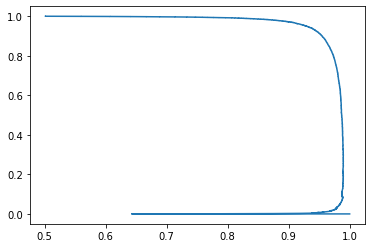

In [32]:
precision, recall, thresholds = precision_recall_curve(Y_test, probs)
plt.plot(precision, recall)

In [33]:
fnames = np.array(transformer.get_feature_names())

In [34]:
fnames[np.argsort(-np.abs(clf.coef_[0]))][:100]

array(['special_char_distr__*', "special_char_distr__'", 'char_distr__. ',
       'char_distr__.. ', 'char_distr__, ',
       'pos_tag_chunks_distr__, NP VP', 'masked_stop_words_distr__, but',
       'char_distr__,', 'special_char_distr__,', 'char_distr__’',
       'masked_stop_words_distr__. but', 'masked_stop_words_distr__, and',
       'pos_tag_chunks_distr__PP NP .', 'pos_tag_chunks_distr__NP CC',
       'special_char_distr__"', 'freq_func_words__its', "char_distr__'",
       'special_char_distr__!', 'masked_stop_words_distr__its',
       'special_char_distr__.', 'char_distr__ ht',
       'pos_tag_chunks_distr__. CC', 'special_char_distr__?',
       'pos_tag_distr__NN NN', 'pos_tag_distr__IN', 'char_distr__snt',
       'pos_tag_chunks_distr__. NP VP', 'pos_tag_chunks_distr__, CC',
       'masked_stop_words_distr__NN but',
       'pos_tag_chunks_distr__NP NP NP', 'char_distr__lol',
       'pos_tag_distr__NN NN NN', 'char_distr__ - ',
       'masked_stop_words_distr__CD NNS',
       